# GENFI project
**Date:** 12/07/2023

**Author:** Dr. Siddharth Ramanan, MRC Cognition and Brain Sciences Unit, University of Cambridge, UK

## Project details

**Overall aims and methods:** Examine cognitive, clinical and behavioural heterogeneity in frontotemporal dementia gene carriers

**People involved:** Siddharth Ramanan (lead), Danyal Akarca, Shalom Henderson, Matthew Rouse, Karalyn Patterson, James B. Rowe, Matthew A. Lambon Ralph + GENFI collaborators

**Dataset description:** Data are from Data Freeze 6. Having a quick look at the Excel files that James has emailed over (22/6/23), there are 5 data files in total:
- Biosamples
- Clinical
- Demographics
- Imaging
- Neuropsychology

**Data dictionary:** There doesn't seem to be one. There are legends and codes embedded in the excel sheet (e.g., if 0 then presymptomatic, etc.) but these aren't being read properly into the df. Best to document these as we go.

**Issues to be aware of:**

**Location of files:** C:\Users\sr06\ownCloud\Projects\In Progress\GENFI_JBR. This link contains subfolders for:
- Code
- Data
- Data request form
- Manuscript and figures

## Read data and load relevant packages

In [188]:
# load relevant packages
import numpy as np # import numpy
import pandas as pd # import pandas library for data wrangling
import matplotlib # import matplotlib library for plotting
from matplotlib import pyplot as plt # import pyplot from matplotlib library for plotting
import random # import random library
import sklearn as sklearn # import sklearn library
import seaborn as sns # import seaborn for plotting
from IPython.display import display #  for displaying data

# adjustments to visualising within this notebook
%matplotlib inline
pd.options.display.max_columns = None # to show all cols when viewing data
plt.rcParams['figure.figsize'] = [20, 20] # increase size of plots within Jupyter notebook (this may still cut out some data for inline viz)

Having a quick look at the Excel files from data freeze 6 that James has emailed over (22/6/23), there are 5 data files in total:
- Biosamples
- Clinical
- Demographics
- Imaging
- Neuropsychology

Each of these Excel files has two sheets (GENFI1 and GENFI2) corresponding to each wave of the GENFI, with the same colnames. When I looked at some of the IDs (e.g., GRN161) they have different dates of assessment between GENFI1 and GENFI2 which leads me to believe that GENFI2 is an extension of GENFI1, with no replication of time-stamped data between these two sheets. I will import both sheets and concatenate them together. Where Visit values < 10, source is GENFI1 else GENFI2. Later, I'll repeat these steps for other variables and then left join them with genfi_dem as and when needed.

In [ ]:
# I will import all the five datasets, concatenate across GENFI1 & GENFI2 sheets and then left_join them.

# demographics data
all_genfi_dem = pd.read_excel("../Data/FINAL_BLINDED_GENFI_DEMOGRAPHICS_DF6.xlsx", sheet_name=None)

# clinical data
all_genfi_clinical = pd.read_excel("../Data/FINAL_BLINDED_GENFI_CLINICAL_DF6.xlsx", sheet_name=None)

# neuropsych data
all_genfi_neuropsy = pd.read_excel("../Data/FINAL_BLINDED_GENFI_NEUROPSYCH_DF6.xlsx", sheet_name=None)

# imaging data
all_genfi_imaging = pd.read_excel("../Data/FINAL_BLINDED_GENFI_IMAGING_DF6.xlsx", sheet_name=None)

# biosamples data
all_genfi_biosamp = pd.read_excel("../Data/FINAL_BLINDED_GENFI_BIOSAMPLES_DF6.xlsx", sheet_name=None)

In [ ]:
# for all dfs, check if both sheets are read in
all_genfi_dem.keys();
all_genfi_clinical.keys();
all_genfi_neuropsy.keys();
all_genfi_imaging.keys();
all_genfi_biosamp.keys()

In [ ]:
# For all dfs, concatenate both sheets into one df

# demographics
genfi_dem = pd.concat(all_genfi_dem, ignore_index=True);
genfi_dem.head(20)
# to visualise the full dataset, use the code below but be aware it is computationally expensive.
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#display(genfi_dem)

In [ ]:
# clinical
genfi_clinical = pd.concat(all_genfi_clinical, ignore_index=True);
genfi_clinical.head(20)

In [ ]:
# neuropsych
genfi_neuropsy = pd.concat(all_genfi_neuropsy, ignore_index=True);
genfi_neuropsy.head(20)

In [ ]:
# imaging
genfi_imaging = pd.concat(all_genfi_imaging, ignore_index=True);
genfi_imaging.head(20)

In [ ]:
# biosamples
genfi_biosamp = pd.concat(all_genfi_biosamp, ignore_index=True);
genfi_biosamp.head(20)

## Data cleaning and organising

All data frames have been read in. As the focus of this study is on clinical and neuropsych vars, I will now merge the clinical and neuropsych data with the demographic data. Once I've decided which pts to keep, I will then left_join the imaging and biosamples data.

In [ ]:
# calling this df as genfi_behav (for all behavioural data)
# first, I merge demographic and clinical data
genfi_demclin = pd.merge(genfi_dem, 
                         genfi_clinical, 
                         how="left", 
                         left_on=["Blinded Code", "Visit"], 
                         right_on=["Blinded Code", "Visit"], 
                         suffixes=('', '_y'));

# merge neuropsych data
genfi_behav = pd.merge(genfi_demclin, 
                       genfi_neuropsy, 
                       how="left", 
                       left_on=["Blinded Code", "Visit"], 
                       right_on=["Blinded Code", "Visit"], 
                       suffixes=('', '_z'));

# remove duplicated columns (indicated by suffixes _y and _z)
genfi_behav.drop(genfi_behav.filter(regex='_y$').columns, axis=1, inplace=True);
genfi_behav.drop(genfi_behav.filter(regex='_z$').columns, axis=1, inplace=True);

# extract colnames to see if everything aligns ok
column_names = list(genfi_behav);
column_names

A number of variables such as Genetic status, Mother/Father affected need to be recoded in the data frame. Doing that below using the keys detailed within the first 4 rows of the dataset.

In [ ]:
# extract the first four rows to understand which cols need recoding
genfi_behav.head(20)

In [ ]:
# first make a copy of the df genfi_behav_drop so that the original is not altered everytime we make a change in the copy
genfi_behav_drop1 = genfi_behav.copy()

# the keys for many variables are stored in both the first 4 and last 4 rows
# drop the first 4 rows and the last 4 rows of the df so recoding becomes easier
genfi_behav_drop2 = genfi_behav_drop1.iloc[4:]
genfi_behav_dropkey1 = genfi_behav_drop2.iloc[:-4]
len(genfi_behav_dropkey1)

# make a copy of the genfi_behav_dropkey df that we can modify it safely without impacting the previous version
genfi_behav_dropkey = genfi_behav_dropkey1.copy()

### Recoding variables

In [ ]:
# in this new dropkey df, recode the following vars:
# note that it will produce a standard warning as you are replacing the value in the df using "inplace"

# recode Genetic Status 1
genfi_behav_dropkey['Genetic status 1'].replace(["P", "A"], ['At-risk', "Symptomatic"], inplace=True)

# recode Genetic Status 2 (per JBR mail on 11/7/23, the code for 0,1,2 are described below)
genfi_behav_dropkey['Genetic status 2'].replace([0, 1, 2], ['Non-carrier', "Carrier-asymptomatic", "Carrier-symptomatic"], inplace=True)

# recode Awareness of Genetic Status
genfi_behav_dropkey["Awareness of genetic status"].replace([0, 1, 99], ["Not aware", "Aware", np.NaN], inplace=True)

# recode Mother Affected
genfi_behav_dropkey['Mother Affected'].replace([1, 0], ['Affected', "Unknown"], inplace=True)

# recode Father Affected
genfi_behav_dropkey['Father Affected'].replace([1, 0], ['Affected', "Unknown"], inplace=True)

# recode Age at Death
genfi_behav_dropkey['AAD'].replace(2, np.NaN, inplace=True)
# do a backfill (fill="up") as for some (e.g., GRN001), their age of death is reflected only in their last data point
genfi_behav_dropkey["AAD"] = genfi_behav_dropkey.groupby("Blinded Code")["AAD"].bfill()

# recode Gender
genfi_behav_dropkey['Gender'].replace([0, 1], ['Female', "Male"], inplace=True)

# recode Handedness
genfi_behav_dropkey['Handedness'].replace([0, 1, 2], ["Right", "Left", "Ambidextrous"], inplace=True)

# recode bvFTD criteria
genfi_behav_dropkey['Rascovsky'].replace([1, 2], ['Probable', "Possible"], inplace=True)

# recode PPA criteria
genfi_behav_dropkey['Gorno-Tempini'].replace([1, 2, 3, 4], ['PPA-NOS', "nfvPPA", "svPPA", "lvPPA"], inplace=True)

# recode ALS criteria
genfi_behav_dropkey['El-Escorial'].replace([-1, 1, 2, 3, 4], [np.NaN, "Definite", "Probable", "Lab-supported", "Possible"], inplace=True)

# recode Seizures
genfi_behav_dropkey['Seizures'].replace([1, 2], ['Recent/active', "Possible"], inplace=True)

# Create a source column to know which participants are from GENFI wave 1 vs. wave 2
# All GENFI2 participants have their Visit coded as double digits so I use this as a marker
genfi_behav_dropkey['Source'] = np.where(genfi_behav_dropkey['Visit'] > 10, 'GENFI2', 'GENFI1');

# I will also rename the Blinded Code column to ID and Visit to VisitNumber so I can later create another Visit column that labels each visit as a single numeric value grouped within ID
genfi_behav_dropkey.rename(columns={"Blinded Code": "ID", "Visit": "VisitNumber"}, inplace=True)

# now I create a new column called Visit where I create a cumulative count of each row grouped within ID
genfi_behav_dropkey["Visit"] = genfi_behav_dropkey.groupby("ID").cumcount()+1

# also create a lag count for the number of days between consecutive assessments so that I can find IDs who visit after a long break
genfi_behav_dropkey["Date of assessment"] = pd.to_datetime(genfi_behav_dropkey["Date of assessment"])

genfi_behav_dropkey["LagDaysBwAx"] = (genfi_behav_dropkey.groupby("ID")["Date of assessment"]
                                     .diff()
                                     .dt.days
                                     .fillna(0, downcast="int"))

There are three columns called First symptoms 1,2,3. The values here are coded alphanumerically. The corresponding codes for these are assigned to clinical symptoms such as Disinhibition (B1), Apathy (B2) etc. To replace these first symptom codes with the actual string values, I will create a dictionary which will make substitution easier.

In [71]:
# create dictionary of symptoms
genfi_dict_sx = {"B1": "Disinhibition",
                "B2": "Apathy",
                "B3": "Empathy",
                "B4": "OCD",
                "B5": "Appetite",
                "B6": "Emotions",
                "B7": "Trusting",
                "C1": "Vis. Hallucinations",
                "C2": "Aud. Hallucinations",
                "C3": "Tact. Hallucinations",
                "C4": "Delusions",
                "C5": "Depression",
                "C6": "Anxiety",
                "C7": "Lability",
                "C8": "Aggression",
                "C9": "Euphoria",
                "C10": "Aberr. Motor",
                "C11": "Hypersexuality",
                "C12": "Hyperreligiousity",
                "C13": "Sleep",
                "C14": "Humour", 
                # language disturbances
                "D1": "Articulation",
                "D2": "Fluency",
                "D3": "Grammar",
                "D4": "Retrieval",
                "D5": "Repetition",
                "D6": "Sent. Comprehension",
                "D7": "Word Comprehension",
                "D8": "Dyslexia",
                "D9": "Dysgraphia",
                "D10": "Func. Communication",
                # cognitive disturbances
                "E1": "Memory",
                "E2": "Orientation", 
                "E3": "Judg/Prob. Solv.",
                "E4": "Comm. Affairs",
                "E5": "Hobbies",
                "E6": "Personal Care",
                "E7": "Person Recogn.",
                "E8": "Topog. Memory",
                "E9": "Visuospatial",
                "E10": "Attention",
                "E11": "Bradyphrenia",
                # motor disturbances
                "F1": "Dysarthria",
                "F2": "Dysphagia",
                "F3": "Tremor",
                "F4": "Slowness",
                "F5": "Weakness",
                "F6": "Gait",
                "F7": "Falls",
                "F8": "Hands",
                # autonomic
                "G1": "BP",
                "G2": "Gastro",
                "G3": "Thermo",
                "G4": "Urinary",
                "G5": "Pain",
                "H1": "Sounds",
                "H2": "Smell",
                "H3": "Unexplained",
                "H4": "Breathing"
                }

# now replace First symptom, First symptom.1 and First symptom.2 cols with these dictionary values
genfi_behav_dropkey["First symptom"].replace(genfi_dict_sx, inplace=True)
genfi_behav_dropkey["First symptom.1"].replace(genfi_dict_sx, inplace=True)
genfi_behav_dropkey["First symptom.2"].replace(genfi_dict_sx, inplace=True)

# View these changes to see if they have taken place
genfi_behav_dropkey.head(20) # looks like it worked!

# If needed, sort this data into a new df to arrange data by ID and visit to check if data looks OK
#genfi_behav_dropkey_sorted = genfi_behav_dropkey.sort_values(['ID', 'Visit'], ascending=True)

,ID,Blinded Site,VisitNumber,Date of assessment,Genetic Group,Mutation,Blinded Family,Genetic status 1,Genetic status 2,Awareness of genetic status,DOB,Gender,Handedness,Education,Employment,Ethnicity,Mean family AAO,Age at visit,EYO,Mother Affected,Diagnosis,AAO,AAD,Father Affected,Diagnosis.1,AAO.1,AAD.1,No_of_sibs,No_of_affected_sibs,Diagnosis_1,AAO_1,AAD_1,Diagnosis_2,AAO_2,AAD_2,Diagnosis_3,AAO_3,AAD_3,Diagnosis_4,AAO_4,AAD_4,Diagnosis_5,AAO_5,AAD_5,Diagnosis_6,AAO_6,AAD_6,Diagnosis_7,AAO_7,AAD_7,Diagnosis_8,AAO_8,AAD_8,Mean Family AAO,Affected,Age at Onset,First symptom,First symptom.1,First symptom.2,Rascovsky,Gorno-Tempini,El-Escorial,Affected.1,Disinhibition,Apathy,Empathy,OCD,Appetite,Affected.2,Vis_hal,Aud_hal,Tac_hal,Delusions,Depression,Anxiety,Affected.3,Artic,Fluency,Grammar,Retrieval,Repetition,Sent_comp,Word_comp,Dyslexia,Dysgraphia,Func_comm,Affected.4,Memory,Visuospatial,Judg_prob_solv,Attention,Affected.5,Dysarthria,Dysphagia,Tremor,Slowness,Weakness,Gait,Falls,Seizures,Stroke,TBI,Hypertension,Hyperchol,Diabetes,EMG,Supranuclear,Bulbar,Pseudobulbar,Myoclonus,Rest_tremor,Post_tremor,Dystonia,Bradykinesia,Rigidity,Limb_apraxia,Alien_limb,Fascic_UL,Fascic_LL,Spasticity_UL,Spasticity_LL,Weakness_UL,Weakness_LL,Hyperreflexia_UL,Hyperreflexia_LL,Ataxia,Abnormal_gait,Type,Severity,Memory.1,Everyday_Skills,Self_Care,Abnormal_Behaviour,Mood,Beliefs,Eating,Sleep,Stereotypic_Behaviour,Motivation,CBI_Total,FRS_%,ALSFRS_total,FTLD-CDR-SOB,FTLD-CDR-GLOBAL,CDR-SOB,GENFI-CDR-SOB,GENFI-CDR-GLOBAL,BEHAV-SOB,PASS-SOB,Behaviour,Emotions,Trusting,Neuropsych,Lability,Aggression,Euphoria,Aberr_motor,Hypersexuality,Hyperreligiousity,Humour,Language,Cognitive,Orientation,Comm_affairs,Hobbies,Personal_care,Person_recog,Topo_memory,Bradyphrenia,Motor,Hands,Affected.6,Autonomic,BP,Gastro,Thermo,Urinary,Pain,Affected.7,Sounds,Smell,Unexplained,Breathing,Smoking,Alcohol,Rec_drugs,Autoimmune,Drug_history,No_of_drugs,MMSE,Eyelid,Face_weakness,Neck_weakness,Neck_rigidity,Resp_weakness,Myoclonus_L,Myoclonus_R,Rest_tremor_L,Rest_tremor_R,Post_tremor_L,Post_tremor_R,Dystonia_L,Dystonia_R,Chorea_L,Chorea_R,Bradykinesia_UL_L,Bradykinesia_UL_R,Bradykinesia_LL_L,Bradykinesia_LL_R,Rigidity_L,Rigidity_R,Limb_apraxia_L,Limb_apraxia_R,Alien_limb_L,Alien_limb_R,Cortical_sensory_L,Cortical_sensory_R,Fascic_UL_L,Fascic_UL_R,Fascic_LL_L,Fascic_LL_R,Spasticity_UL_L,Spasticity_UL_R,Spasticity_LL_L,Spasticity_LL_R,Weakness_UL_L,Weakness_UL_R,Weakness_LL_L,Weakness_LL_R,Hyperreflexia_UL_L,Hyperreflexia_UL_R,Hyperreflexia_LL_L,Hyperreflexia_LL_R,Ataxia_UL_L,Ataxia_UL_R,Ataxia_LL_L,Ataxia_LL_R,Affected.8,Arising,Sitting,Post_instability,Sleep.1,mIRI_total,mIRI_EC,mIRI_PT,RSMS_total,RSMS_EX,RSMS_SP,Log_memory_immediate,DS_F_score,DS_F_max,DS_B_score,DS_B_max,TMTA_time,TMTA_errors,TMTA_lines,TMTB_time,TMTB_errors,TMTB_lines,Digit_symbol,Boston_naming,VF_animals,VF_vegetables,VF_F,VF_A,VF_S,Log_memory_delayed,Log_memory_time,Block_design,Benson_figure_copy,C+C,Benson_figure_recall,Copy_recall_time,Benson_recognition,FCRST_free,FCRST_total,Stroop_color_uerrors,Stroop_color_scerrors,Stroop_color_time,Stroop_word_uerrors,Stroop_word_scerrors,Stroop_word_time,Stroop_ink_uerrors,Stroop_ink_scerrors,Stroop_ink_time,FCRST_del_free,FCRST_del_total,Faux_pas_totalFP,Faux_pas_totalNFP,Faux_pas_totalALL,Faux_pas_SUBSCORE,Ekman_happiness,Ekman_surprise,Ekman_disgust,Ekman_fear,Ekman_anger,Ekman_sadness,Ekman_neutral,Ekman_all,Ekman_SUBSCORE,MiniSEA_total,Unnamed: 55,Source,Visit,LagDaysBwAx,Total
4,GRN001,GENFI_YD,1.0,2012-01-30,GRN,G35fs,FAM449,At-risk,Non-carrier,Not aware,1984-03-14,Female,Left,16,0.0,0.0,56.0,27.879535,-28.120465,Affected,PPA,56.0,61.0,Unknown,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0

I now examine how many IDs have more than 3 occurrences as I want keep those IDs that have more than 2 longitudinal time point data.

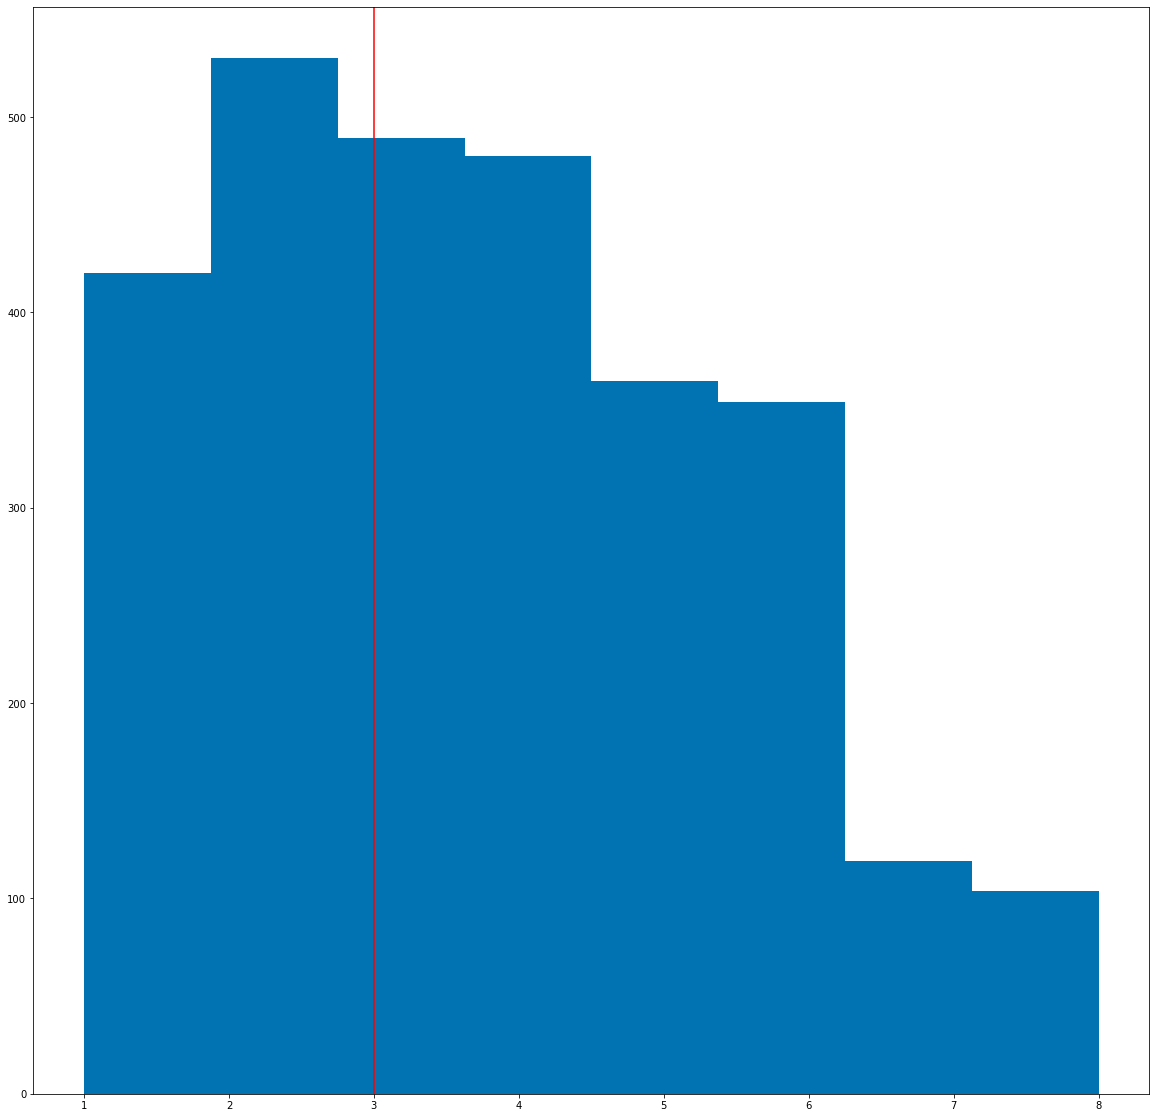

In [189]:
genfi_behav_dropkey["Total"] = genfi_behav_dropkey.groupby("ID")["ID"].transform('count')

# plot these values
plt.hist(genfi_behav_dropkey["Total"], bins=8)
plt.axvline(x=3, color = "red")

From the plot above, it looks like some 900+ data points that have 2+ occurrences. I have drawn a vertical red line at 3 to show the number of data points that have 3 and + occurrences. I now use the LagDaysBwAx variable to examine the gap between consecutive assessments for each person. This will reveal patients who are visiting after a long break. I make this plot by ID and by genetic group.

<AxesSubplot:xlabel='Visit', ylabel='LagDaysBwAx'>

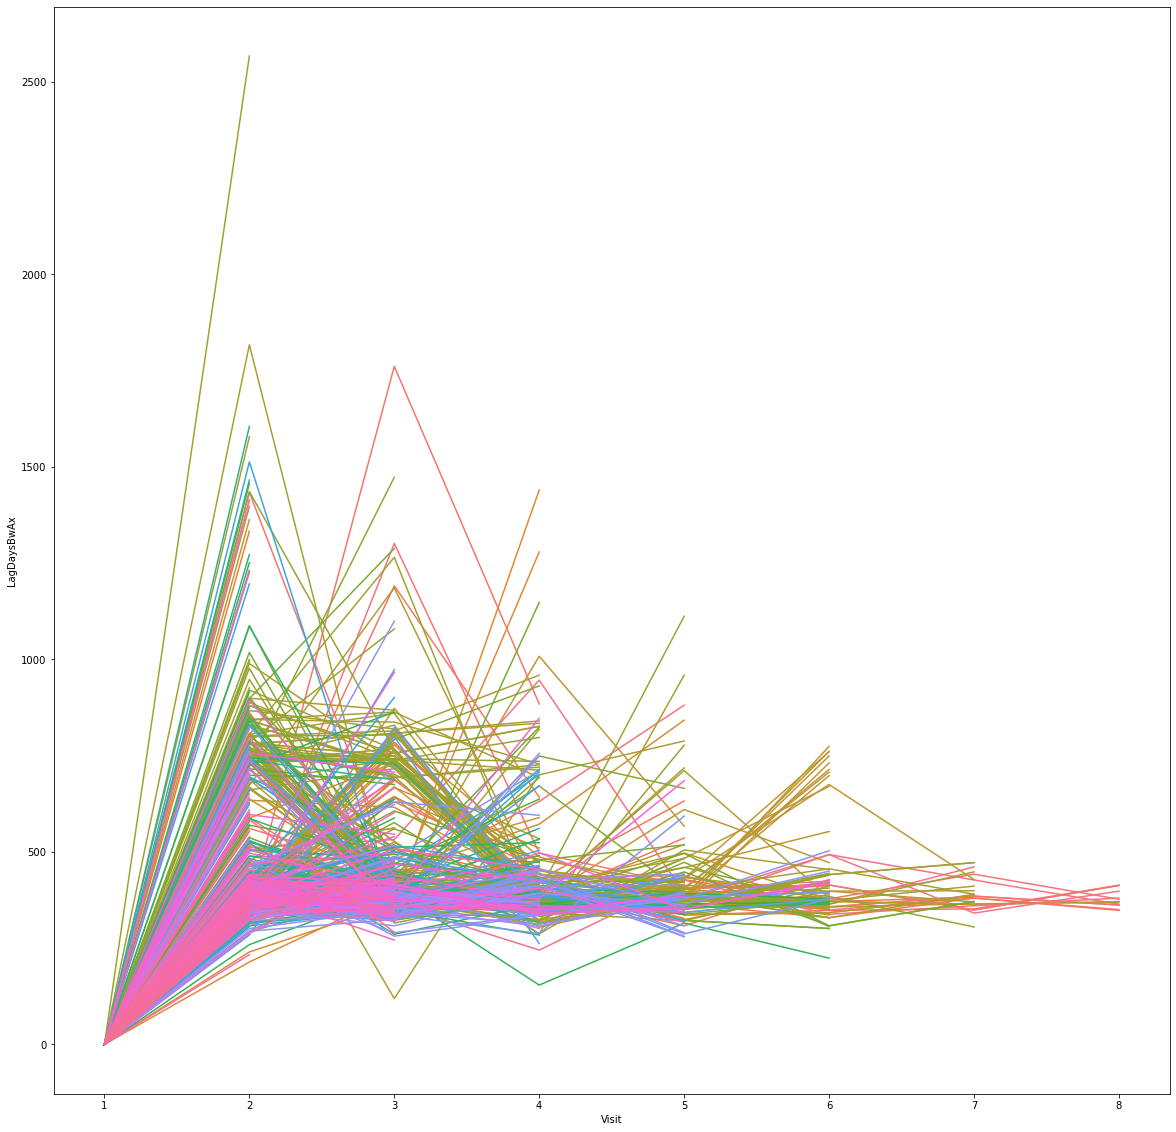

In [190]:
# for each ID
sns.lineplot(data=genfi_behav_dropkey, x="Visit", y="LagDaysBwAx", hue="ID", legend=False) # removing the legend otherwise it'll produce one for every ID

<AxesSubplot:xlabel='Visit', ylabel='LagDaysBwAx'>

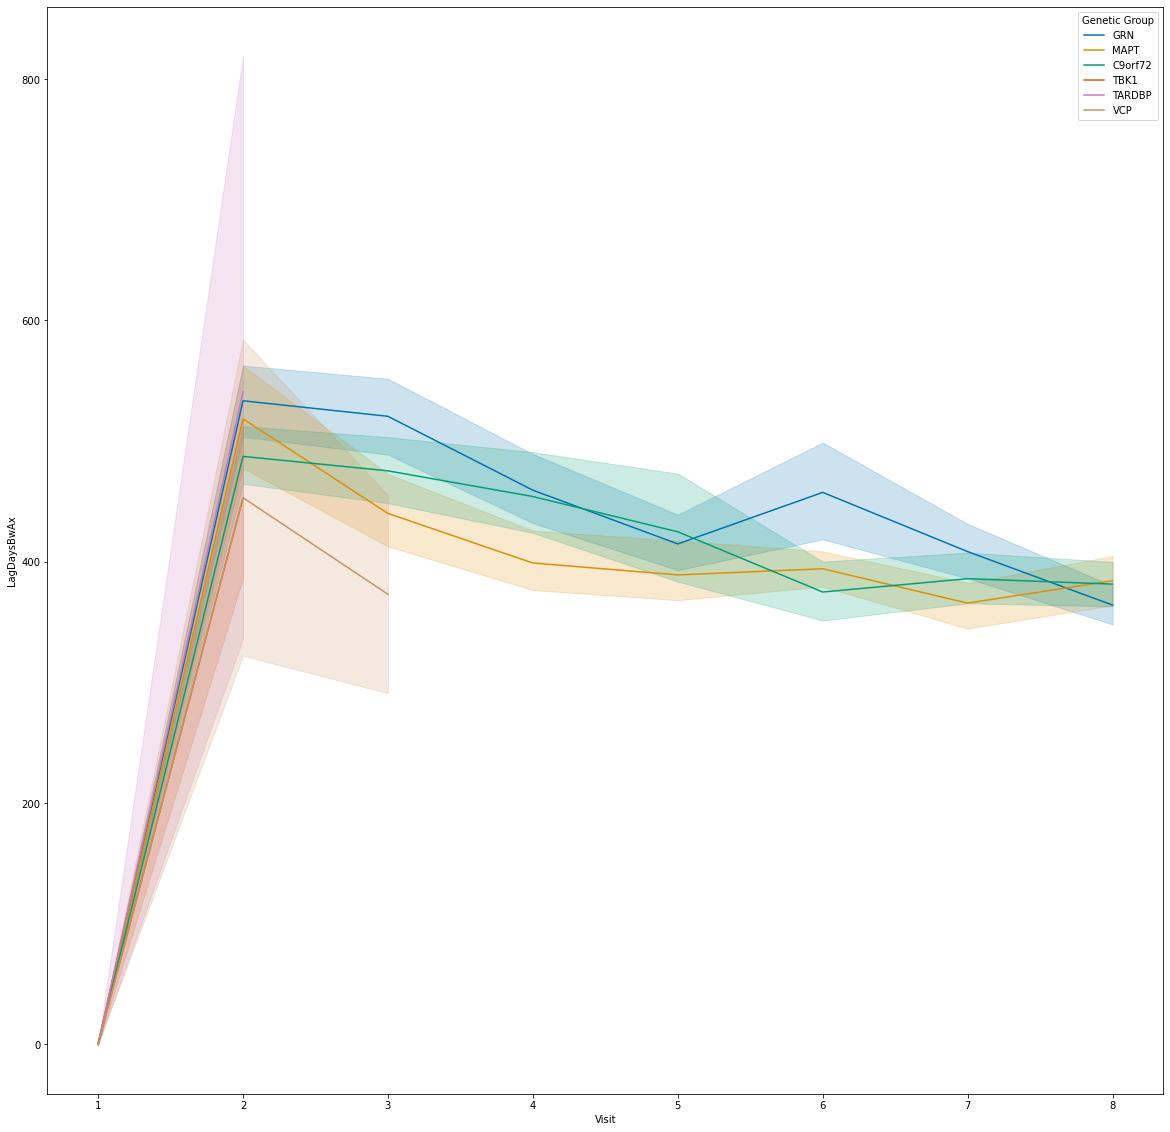

In [191]:
# by genetic group
sns.lineplot(data=genfi_behav_dropkey, x="Visit", y="LagDaysBwAx", hue="Genetic Group")

<AxesSubplot:xlabel='Visit', ylabel='LagDaysBwAx'>

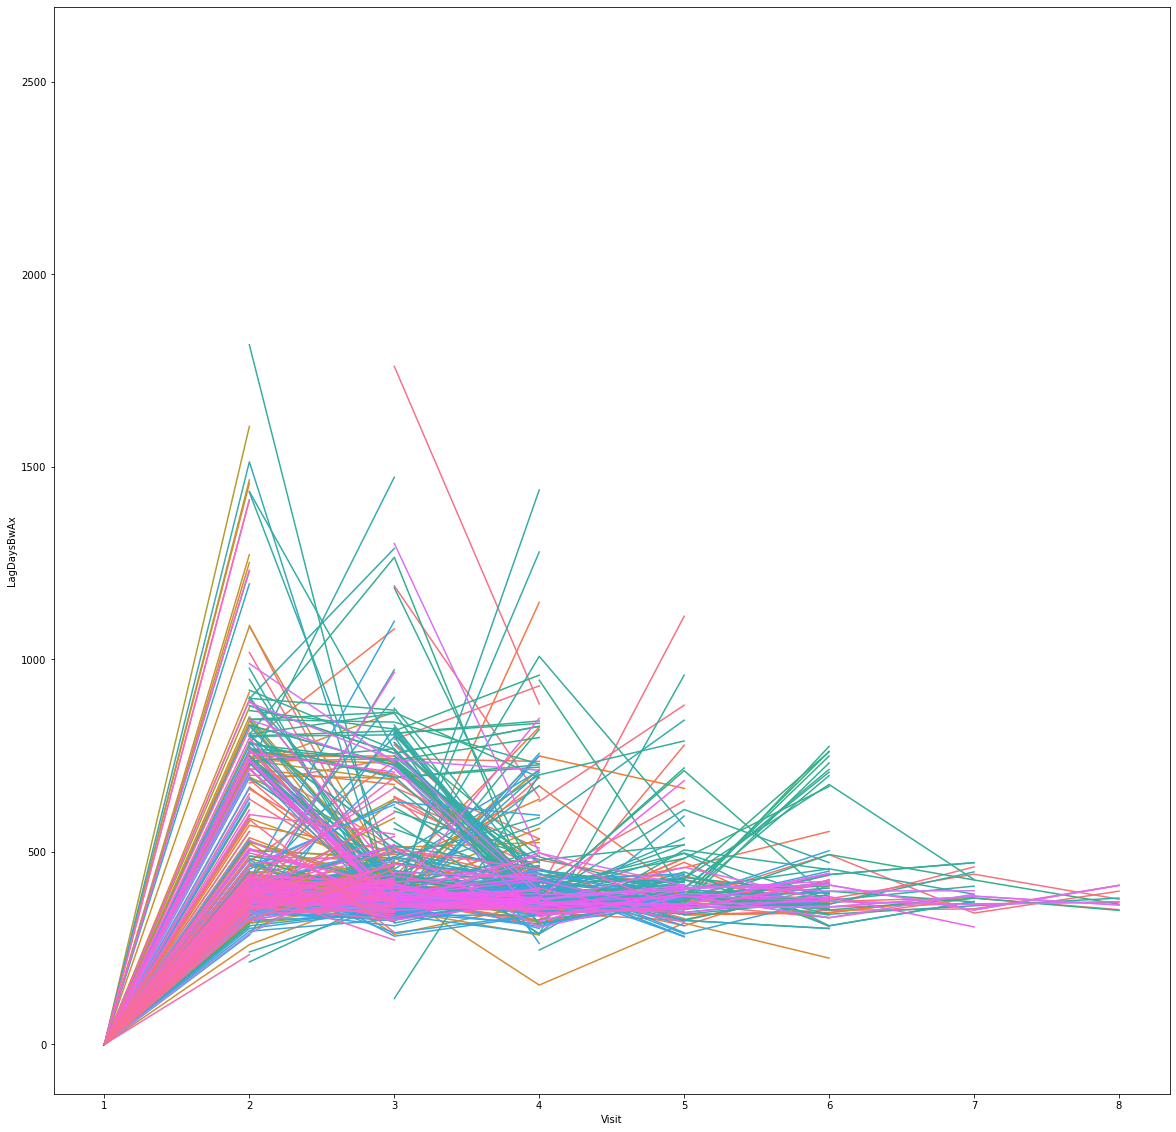

In [192]:
# lets examine what the data look like if I look only within GENFI2, where there have been more regular followups
genfi_behav_dropkey_GENFI2 = genfi_behav_dropkey[genfi_behav_dropkey["Source"] == "GENFI2"]

sns.lineplot(data=genfi_behav_dropkey_GENFI2, x="Visit", y="LagDaysBwAx", hue="ID", legend=False)

These above plots are super helpful but before I proceed with selecting which patients to keep for the analyses, I need to understand the overall nature of missing data there are.

### Missing data visualisation

The next step is to examine how many missing data there are for the neuropsych variables for all patients across GENFI1 and GENFI2. This will help me understand whether I should analyse GENFI1 also or just focus on GENFI2. I will create a copy of my df, keep mainly the neuropsych variables, recode them as Missing or Present, stratify the dataset by Source, and make a raster plot (as a side note, selecting both single and a range of cols together seems incredibly complicated in Pandas as opposed to Tidyverse...).

[Text(0.5, 1.0, 'GENFI2')]

<Figure size 720x432 with 0 Axes>

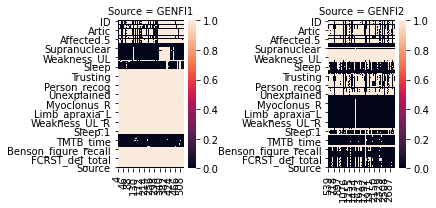

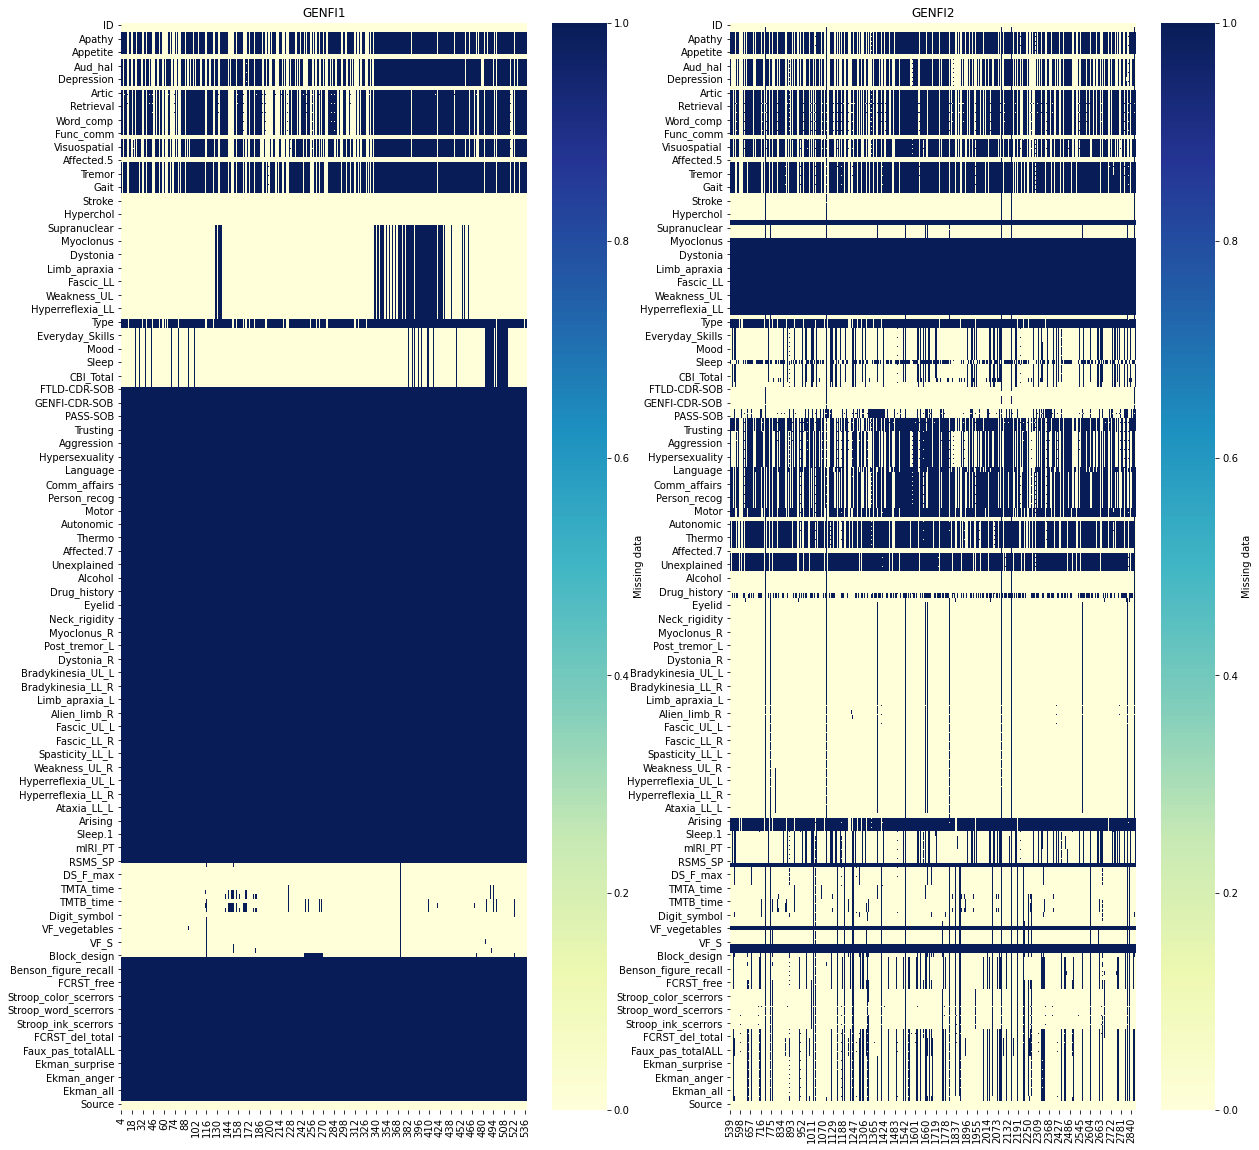

In [198]:
# select the vars of interest and save it as a copy of the df
genfi_behav_dropkey_missingInspection = genfi_behav_dropkey.copy()

# create a list of columns that you want to keep (there may be a faster way to index single and a range of cols together)
cols = genfi_behav_dropkey_missingInspection.columns.values

# alter this list to keep only the cols of interest
cols = ['ID', 'Source', 'Visit', 'Affected.1', 'Disinhibition', 'Apathy', 'Empathy',
       'OCD', 'Appetite', 'Affected.2', 'Vis_hal', 'Aud_hal', 'Tac_hal',
       'Delusions', 'Depression', 'Anxiety', 'Affected.3', 'Artic',
       'Fluency', 'Grammar', 'Retrieval', 'Repetition', 'Sent_comp',
       'Word_comp', 'Dyslexia', 'Dysgraphia', 'Func_comm', 'Affected.4',
       'Memory', 'Visuospatial', 'Judg_prob_solv', 'Attention',
       'Affected.5', 'Dysarthria', 'Dysphagia', 'Tremor', 'Slowness',
       'Weakness', 'Gait', 'Falls', 'Seizures', 'Stroke', 'TBI',
       'Hypertension', 'Hyperchol', 'Diabetes', 'EMG', 'Supranuclear',
       'Bulbar', 'Pseudobulbar', 'Myoclonus', 'Rest_tremor',
       'Post_tremor', 'Dystonia', 'Bradykinesia', 'Rigidity',
       'Limb_apraxia', 'Alien_limb', 'Fascic_UL', 'Fascic_LL',
       'Spasticity_UL', 'Spasticity_LL', 'Weakness_UL', 'Weakness_LL',
       'Hyperreflexia_UL', 'Hyperreflexia_LL', 'Ataxia', 'Abnormal_gait',
       'Type', 'Severity', 'Memory.1', 'Everyday_Skills', 'Self_Care',
       'Abnormal_Behaviour', 'Mood', 'Beliefs', 'Eating', 'Sleep',
       'Stereotypic_Behaviour', 'Motivation', 'CBI_Total', 'FRS_%',
       'ALSFRS_total', 'FTLD-CDR-SOB', 'FTLD-CDR-GLOBAL', 'CDR-SOB',
       'GENFI-CDR-SOB', 'GENFI-CDR-GLOBAL', 'BEHAV-SOB', 'PASS-SOB',
       'Behaviour', 'Emotions', 'Trusting', 'Neuropsych', 'Lability',
       'Aggression', 'Euphoria', 'Aberr_motor', 'Hypersexuality',
       'Hyperreligiousity', 'Humour', 'Language', 'Cognitive',
       'Orientation', 'Comm_affairs', 'Hobbies', 'Personal_care',
       'Person_recog', 'Topo_memory', 'Bradyphrenia', 'Motor', 'Hands',
       'Affected.6', 'Autonomic', 'BP', 'Gastro', 'Thermo', 'Urinary',
       'Pain', 'Affected.7', 'Sounds', 'Smell', 'Unexplained',
       'Breathing', 'Smoking', 'Alcohol', 'Rec_drugs', 'Autoimmune',
       'Drug_history', 'No_of_drugs', 'MMSE', 'Eyelid', 'Face_weakness',
       'Neck_weakness', 'Neck_rigidity', 'Resp_weakness', 'Myoclonus_L',
       'Myoclonus_R', 'Rest_tremor_L', 'Rest_tremor_R', 'Post_tremor_L',
       'Post_tremor_R', 'Dystonia_L', 'Dystonia_R', 'Chorea_L',
       'Chorea_R', 'Bradykinesia_UL_L', 'Bradykinesia_UL_R',
       'Bradykinesia_LL_L', 'Bradykinesia_LL_R', 'Rigidity_L',
       'Rigidity_R', 'Limb_apraxia_L', 'Limb_apraxia_R', 'Alien_limb_L',
       'Alien_limb_R', 'Cortical_sensory_L', 'Cortical_sensory_R',
       'Fascic_UL_L', 'Fascic_UL_R', 'Fascic_LL_L', 'Fascic_LL_R',
       'Spasticity_UL_L', 'Spasticity_UL_R', 'Spasticity_LL_L',
       'Spasticity_LL_R', 'Weakness_UL_L', 'Weakness_UL_R',
       'Weakness_LL_L', 'Weakness_LL_R', 'Hyperreflexia_UL_L',
       'Hyperreflexia_UL_R', 'Hyperreflexia_LL_L', 'Hyperreflexia_LL_R',
       'Ataxia_UL_L', 'Ataxia_UL_R', 'Ataxia_LL_L', 'Ataxia_LL_R',
       'Affected.8', 'Arising', 'Sitting', 'Post_instability', 'Sleep.1',
       'mIRI_total', 'mIRI_EC', 'mIRI_PT', 'RSMS_total', 'RSMS_EX',
       'RSMS_SP', 'Log_memory_immediate', 'DS_F_score', 'DS_F_max',
       'DS_B_score', 'DS_B_max', 'TMTA_time', 'TMTA_errors', 'TMTA_lines',
       'TMTB_time', 'TMTB_errors', 'TMTB_lines', 'Digit_symbol',
       'Boston_naming', 'VF_animals', 'VF_vegetables', 'VF_F', 'VF_A',
       'VF_S', 'Log_memory_delayed', 'Log_memory_time', 'Block_design',
       'Benson_figure_copy', 'C+C', 'Benson_figure_recall',
       'Copy_recall_time', 'Benson_recognition', 'FCRST_free',
       'FCRST_total', 'Stroop_color_uerrors', 'Stroop_color_scerrors',
       'Stroop_color_time', 'Stroop_word_uerrors', 'Stroop_word_scerrors',
       'Stroop_word_time', 'Stroop_ink_uerrors', 'Stroop_ink_scerrors',
       'Stroop_ink_time', 'FCRST_del_free', 'FCRST_del_total',
       'Faux_pas_totalFP', 'Faux_pas_totalNFP', 'Faux_pas_totalALL',
       'Faux_pas_SUBSCORE', 'Ekman_happiness', 'Ekman_surprise',
       'Ekman_disgust', 'Ekman_fear', 'Ekman_anger', 'Ekman_sadness',
       'Ekman_neutral', 'Ekman_all', 'Ekman_SUBSCORE', 'MiniSEA_total']

# keep cols from the cols list
genfi_behav_dropkey_missingInspection = genfi_behav_dropkey_missingInspection[genfi_behav_dropkey_missingInspection.columns.intersection(cols)]

# how many cols in this df?
len(genfi_behav_dropkey_missingInspection.columns)
#242

# inspect
genfi_behav_dropkey_missingInspection.head(10) # looks fine

# visualise missing data, facetted by GENFI1 and GENFI2
plt.figure(figsize=(10,6))
fig = sns.FacetGrid(genfi_behav_dropkey_missingInspection, 
                    col='Source',
                   sharex=False,
                   sharey=False)
fig.map_dataframe(lambda data, color: sns.heatmap(data.isna().transpose()))

# this faceting does not show the unequal number of patients in each wave, rather, its taken only those who are present in both GENFI1 and GENFI2
# I split the df into 2 (for each wave and make a multiplot)
genfi_behav_dropkey_missingInspection_GENFI1 = genfi_behav_dropkey_missingInspection[genfi_behav_dropkey_missingInspection["Source"]=="GENFI1"]
genfi_behav_dropkey_missingInspection_GENFI2 = genfi_behav_dropkey_missingInspection[genfi_behav_dropkey_missingInspection["Source"]=="GENFI2"]

# plot data
fig, axs = plt.subplots(ncols=2) # make a multiplot

# Missing data in GENFI1 (note that due to space constraints in this notebook, all patients are not plotted)
sns.heatmap(genfi_behav_dropkey_missingInspection_GENFI1.isna().transpose(),
            cmap="YlGnBu", # set colour
            cbar_kws={"label": "Missing data"}, # set label name
           ax=axs[0]).set(title="GENFI1") # indicate where to place plot and plot title

# Missing data in GENFI2 (note that due to space constraints in this notebook, all patients are not plotted)
sns.heatmap(genfi_behav_dropkey_missingInspection_GENFI2.isna().transpose(),
           cmap="YlGnBu",
           cbar_kws={"label": "Missing data"},
           ax=axs[1]).set(title="GENFI2")
# looks like GENFI2 has more neuropsych (white tiles indicate available data)
# run each of the above codes as they are (removing the ,ax=axs[0] bit) to visualise missing data in each wave in more detail

Based on the above plot, it is clear that most of the available data are in GENFI2. I will therefore, stick to GENFI2 for the rest of the analyses.

### Focusing on GENFI2 patients with 3 consecutive time point data

Now that GENFI2 is the focus of this data, I will create a copy of the genfi_behav_dropkey dataset and filter to keep only GENFI2 data.

In [207]:
# make a copy of the df
genfi_behav_dropkey_GENFI2 = genfi_behav_dropkey[genfi_behav_dropkey["Source"]=="GENFI2"].copy()

# examine this df
genfi_behav_dropkey_GENFI2.head()

# now keep individuals who have 3 time point data
genfi_behav_dropkey_GENFI2_3tp = genfi_behav_dropkey_GENFI2.groupby('ID').filter(lambda x: len(x) > 2 and len(x) < 4).copy()

# how many rows do we have in this df?
len(genfi_behav_dropkey_GENFI2_3tp)
# 188 patients with 3 time points each = 564 data points
564/3

188.0

In [99]:
len(genfi_behav_dropkey_GENFI2)



,ID,Blinded Site,VisitNumber,Date of assessment,Genetic Group,Mutation,Blinded Family,Genetic status 1,Genetic status 2,Awareness of genetic status,DOB,Gender,Handedness,Education,Employment,Ethnicity,Mean family AAO,Age at visit,EYO,Mother Affected,Diagnosis,AAO,AAD,Father Affected,Diagnosis.1,AAO.1,AAD.1,No_of_sibs,No_of_affected_sibs,Diagnosis_1,AAO_1,AAD_1,Diagnosis_2,AAO_2,AAD_2,Diagnosis_3,AAO_3,AAD_3,Diagnosis_4,AAO_4,AAD_4,Diagnosis_5,AAO_5,AAD_5,Diagnosis_6,AAO_6,AAD_6,Diagnosis_7,AAO_7,AAD_7,Diagnosis_8,AAO_8,AAD_8,Mean Family AAO,Affected,Age at Onset,First symptom,First symptom.1,First symptom.2,Rascovsky,Gorno-Tempini,El-Escorial,Affected.1,Disinhibition,Apathy,Empathy,OCD,Appetite,Affected.2,Vis_hal,Aud_hal,Tac_hal,Delusions,Depression,Anxiety,Affected.3,Artic,Fluency,Grammar,Retrieval,Repetition,Sent_comp,Word_comp,Dyslexia,Dysgraphia,Func_comm,Affected.4,Memory,Visuospatial,Judg_prob_solv,Attention,Affected.5,Dysarthria,Dysphagia,Tremor,Slowness,Weakness,Gait,Falls,Seizures,Stroke,TBI,Hypertension,Hyperchol,Diabetes,EMG,Supranuclear,Bulbar,Pseudobulbar,Myoclonus,Rest_tremor,Post_tremor,Dystonia,Bradykinesia,Rigidity,Limb_apraxia,Alien_limb,Fascic_UL,Fascic_LL,Spasticity_UL,Spasticity_LL,Weakness_UL,Weakness_LL,Hyperreflexia_UL,Hyperreflexia_LL,Ataxia,Abnormal_gait,Type,Severity,Memory.1,Everyday_Skills,Self_Care,Abnormal_Behaviour,Mood,Beliefs,Eating,Sleep,Stereotypic_Behaviour,Motivation,CBI_Total,FRS_%,ALSFRS_total,FTLD-CDR-SOB,FTLD-CDR-GLOBAL,CDR-SOB,GENFI-CDR-SOB,GENFI-CDR-GLOBAL,BEHAV-SOB,PASS-SOB,Behaviour,Emotions,Trusting,Neuropsych,Lability,Aggression,Euphoria,Aberr_motor,Hypersexuality,Hyperreligiousity,Humour,Language,Cognitive,Orientation,Comm_affairs,Hobbies,Personal_care,Person_recog,Topo_memory,Bradyphrenia,Motor,Hands,Affected.6,Autonomic,BP,Gastro,Thermo,Urinary,Pain,Affected.7,Sounds,Smell,Unexplained,Breathing,Smoking,Alcohol,Rec_drugs,Autoimmune,Drug_history,No_of_drugs,MMSE,Eyelid,Face_weakness,Neck_weakness,Neck_rigidity,Resp_weakness,Myoclonus_L,Myoclonus_R,Rest_tremor_L,Rest_tremor_R,Post_tremor_L,Post_tremor_R,Dystonia_L,Dystonia_R,Chorea_L,Chorea_R,Bradykinesia_UL_L,Bradykinesia_UL_R,Bradykinesia_LL_L,Bradykinesia_LL_R,Rigidity_L,Rigidity_R,Limb_apraxia_L,Limb_apraxia_R,Alien_limb_L,Alien_limb_R,Cortical_sensory_L,Cortical_sensory_R,Fascic_UL_L,Fascic_UL_R,Fascic_LL_L,Fascic_LL_R,Spasticity_UL_L,Spasticity_UL_R,Spasticity_LL_L,Spasticity_LL_R,Weakness_UL_L,Weakness_UL_R,Weakness_LL_L,Weakness_LL_R,Hyperreflexia_UL_L,Hyperreflexia_UL_R,Hyperreflexia_LL_L,Hyperreflexia_LL_R,Ataxia_UL_L,Ataxia_UL_R,Ataxia_LL_L,Ataxia_LL_R,Affected.8,Arising,Sitting,Post_instability,Sleep.1,mIRI_total,mIRI_EC,mIRI_PT,RSMS_total,RSMS_EX,RSMS_SP,Log_memory_immediate,DS_F_score,DS_F_max,DS_B_score,DS_B_max,TMTA_time,TMTA_errors,TMTA_lines,TMTB_time,TMTB_errors,TMTB_lines,Digit_symbol,Boston_naming,VF_animals,VF_vegetables,VF_F,VF_A,VF_S,Log_memory_delayed,Log_memory_time,Block_design,Benson_figure_copy,C+C,Benson_figure_recall,Copy_recall_time,Benson_recognition,FCRST_free,FCRST_total,Stroop_color_uerrors,Stroop_color_scerrors,Stroop_color_time,Stroop_word_uerrors,Stroop_word_scerrors,Stroop_word_time,Stroop_ink_uerrors,Stroop_ink_scerrors,Stroop_ink_time,FCRST_del_free,FCRST_del_total,Faux_pas_totalFP,Faux_pas_totalNFP,Faux_pas_totalALL,Faux_pas_SUBSCORE,Ekman_happiness,Ekman_surprise,Ekman_disgust,Ekman_fear,Ekman_anger,Ekman_sadness,Ekman_neutral,Ekman_all,Ekman_SUBSCORE,MiniSEA_total,Unnamed: 55,Source,Visit,LagDaysBwAx,Total
557,C9ORF025,GENFI_GX,11.0,2015-11-03,C9orf72,NaN,FAM495,At-risk,Carrier-asymptomatic,Not aware,1973-02-05,Female,Right,16,0.0,0,NaN,42.740589,-16.859411,Unknown,NaN,NaN,NaN,Affected,bvFTD,52.0,59,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0,0,0,0,0,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.

In [ ]:
# create a df copy so that you can retain only those who have more than 1 time point data
genfi_behav_dropkey_copy = genfi_behav_dropkey.copy()

genfi_behav_keeprows = genfi_behav_dropkey_copy.groupby('ID').filter(lambda x: len(x) > 1)

genfi_behav_keeprows["Blinded Code"].nunique()

In [136]:
colnames(genfi_behav_dropkey_missingInspection)


NameError: name 'colnames' is not defined